# Source
- https://towardsdatascience.com/text-classification-with-no-model-training-935fe0e42180
- https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/blob/master/natural_language_processing/example_text_classification.ipynb

# import librairies

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
from sklearn import metrics, manifold
from tqdm import tqdm

## for processing
import re
import nltk

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for w2v
import gensim
import gensim.downloader as gensim_api

## for BERT
import transformers
import os

# Check GPU

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.0-rc2


In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda()) 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


# Load the dataset

In [4]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )
    
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [5]:
## create dtf
dtf = pd.DataFrame(lst_dics)
dtf.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
print(f'the dataset contains {len(dtf)} news articles')

the dataset contains 200853 news articles


In [7]:
print(f'there are {len(set(dtf.category))} categories in the dataset')
print(set(dtf.category))

there are 41 categories in the dataset
{'QUEER VOICES', 'BUSINESS', 'CRIME', 'POLITICS', 'WORLDPOST', 'RELIGION', 'TRAVEL', 'WEIRD NEWS', 'PARENTING', 'CULTURE & ARTS', 'GOOD NEWS', 'ARTS & CULTURE', 'PARENTS', 'STYLE', 'THE WORLDPOST', 'SPORTS', 'ARTS', 'FOOD & DRINK', 'TECH', 'GREEN', 'EDUCATION', 'HOME & LIVING', 'HEALTHY LIVING', 'COLLEGE', 'COMEDY', 'TASTE', 'ENTERTAINMENT', 'MONEY', 'SCIENCE', 'IMPACT', 'MEDIA', 'STYLE & BEAUTY', 'ENVIRONMENT', 'FIFTY', 'LATINO VOICES', 'WELLNESS', 'DIVORCE', 'WORLD NEWS', 'WEDDINGS', 'WOMEN', 'BLACK VOICES'}


In [8]:
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])        ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"category", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,category,text
64987,POLITICS,Polls Show The Supreme Court Blockade Is Hurti...
32013,POLITICS,Donald Trump Loved To Cite The Nonpartisan Age...
10675,POLITICS,Report: Jared Kushner Met With Special Counsel...
111792,POLITICS,"Inequality, Nick Hanauer and the Patriot's Mor..."
102016,POLITICS,2014's Voting Changes Are Reason for 2015 Reform


In [9]:
print(f'the sample dataset now contains {len(dtf)} news articles related to selected categories {set(dtf.category)}')

the sample dataset now contains 50879 news articles related to selected categories {'TECH', 'ENTERTAINMENT', 'POLITICS'}


# Unsupervised classification principles and approach
- clean data and embed it into the vector space,
- create a topic cluster for each category and embed it into the vector space,
- calculate similarities between every text vector and the topic clusters, then assign it to the closest cluster.
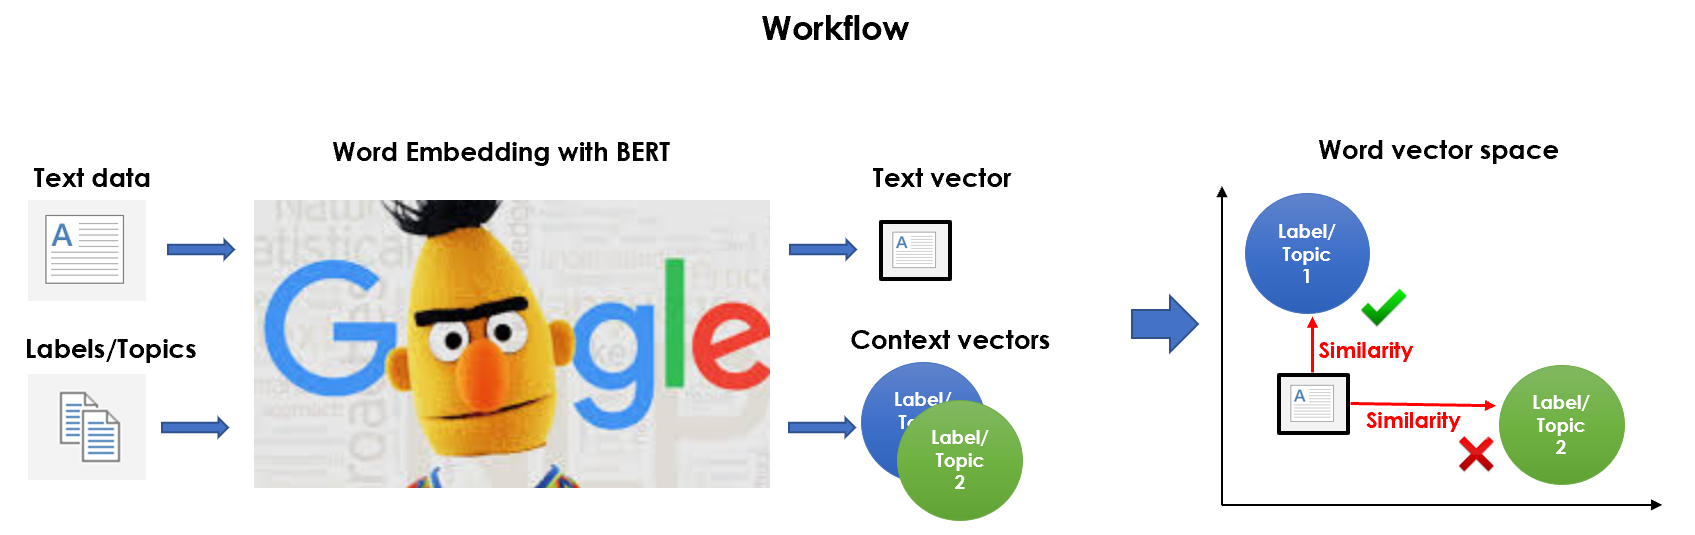

# Text preprocessing
- remove punctuation, convert to lower case
- tokenize text to words
- remove stopwords (nltk)
- Stemming and lemmatisation

In [10]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''

    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [11]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [12]:
dtf["text_clean"] = dtf["text"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
dtf.head()

,category,text,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,morgan freeman devastated sexual harassment cl...


# Create Target Clusters

### Load gensim GloVe word embeddings

In [13]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [14]:
# The gensim package has a very convenient function that returns the most similar words for any given word into the vocabulary
nlp.most_similar(["obama"], topn=3)

[('barack', 0.9254721403121948),
 ('mccain', 0.7590768337249756),
 ('bush', 0.7570987939834595)]

In [15]:
def get_similar_words(lst_words, top, nlp):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=top):
        lst_out.append(tupla[0])
    return list(set(lst_out))

In [16]:
## Create Dictionary {category:[keywords]}
dic_clusters = {}
dic_clusters["ENTERTAINMENT"] = get_similar_words(['celebrity','cinema','movie','music'], top=30, nlp=nlp)
dic_clusters["POLITICS"] = get_similar_words(['gop','clinton','president','obama','republican'], top=30, nlp=nlp)
dic_clusters["TECH"] = get_similar_words(['amazon','android','app','apple','facebook','google','tech'], top=30, nlp=nlp)

In [17]:
## print top 5 closest words
print('Top words per label:')
for k,v in dic_clusters.items():
    print("{0:15}..... {1}".format(k, v[0:5], len(v)))

Top words per label:
ENTERTAINMENT  ..... ['entertainment', 'celebrity', 'hollywood', 'drama', 'music']
POLITICS       ..... ['presidential', 'gop', 'bush', 'gingrich', 'mccain']
TECH           ..... ['users', 'android', 'itunes', 'ios', 'facebook']


### Visualize the selected topics with keyword clusters

<IPython.core.display.Javascript object>


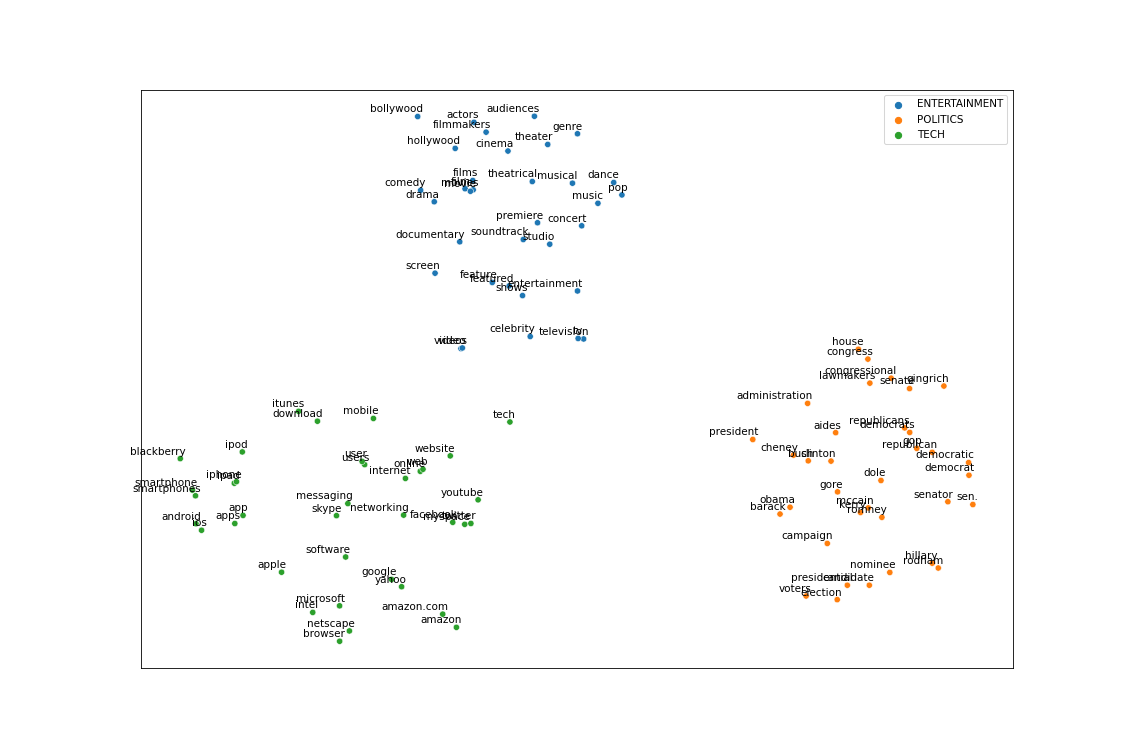

In [20]:
## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]
        
## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf_GloVe = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf_GloVe) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf_GloVe):size], columns=["x","y"], index=v)
    dtf_group["cluster"] = k
    dtf_GloVe = dtf_GloVe.append(dtf_group)
        
## plot
%matplotlib notebook
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=dtf_GloVe, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(dtf_GloVe)):
    ax.annotate(dtf_GloVe.index[i], xy=(dtf_GloVe["x"].iloc[i], dtf_GloVe["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')

In [21]:
%matplotlib inline

# Load Transformers BERT model to create embeddings

In [22]:
## for BERT
import transformers
## bert tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
## bert model
nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


- create average embeddings of sentence
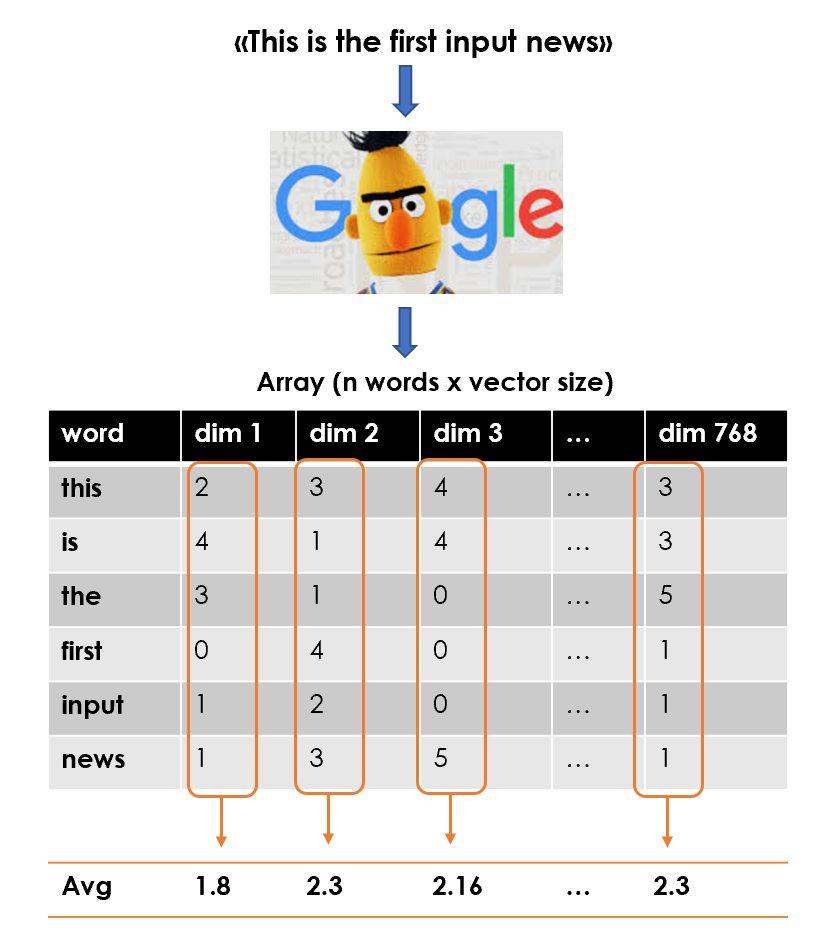

- Use BERT Word Embedding to represent each text with an array (shape: number of tokens x 768) and then summarize each article into a mean vector

In [23]:
## function to apply
def utils_bert_embedding(txt, tokenizer, nlp):
    '''
    Word embedding with Bert (equivalent to nlp["word"]).
    :parameter
        :param txt: string 
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
    :return
        tensor sentences x words x vector (1x3x768) 
    '''
    # tokenize sentence to tokens (integers)
    idx = tokenizer.encode(txt)
    # convert to array of shape (1, num_words+2) - EOS and CLS added
    idx = np.array(idx)[None,:]
    # generate embeddings for each token - output is a tuple
    embedding = nlp(idx)
    # select first member of the tuple, remove first dimension which is 1 to get (num_words,embedding size 712)
    # exclude CLS and EOS tokens
    X = np.array(embedding[0][0][1:-1])
    return X

In [24]:
%%time
## create list of news vector
lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in tqdm(dtf["text_clean"])]

 12%|█████████                                                                    | 6021/50879 [07:55<59:08, 12.64it/s]C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice.
  
C:\Users\lveys\anaconda3\envs\tensorflow_py37\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
100%|██████████████████████████████████████████████████████████████████████████| 50879/50879 [1:09:20<00:00, 12.23it/s]

Wall time: 1h 9min 20s


In [31]:
## create the feature matrix (n news x 768)
X = np.array(lst_mean_vecs)
X.shape

(50879, 768)

In [32]:
X

array([[ 0.30438665,  0.07948505,  0.6763927 , ...,  0.06270284,
        -0.20794474, -0.33524317],
       [-0.37043527, -0.13170178,  0.8771485 , ..., -0.8154713 ,
         0.05773336, -0.32166442],
       [-0.45270374, -0.05354849,  0.08928617, ...,  0.10965689,
        -0.00415117, -0.13247384],
       ...,
       [-0.07823104, -0.33922744,  0.02913927, ..., -0.16773066,
         0.04754737, -0.05037096],
       [ 0.12713456, -0.72594005,  0.66156054, ...,  0.21199942,
        -0.04013521, -0.39460298],
       [-0.3691501 , -0.13852495,  0.42212212, ..., -0.24667093,
        -0.05770339, -0.25885642]], dtype=float32)

- Do the same with the keywords in the target clusters. Each label is identified by a list of words that help BERT to understand the context within the clusters

In [33]:
# Create y as {label:mean_vector}
dic_y = {k:utils_bert_embedding(v, tokenizer, nlp).mean(0) for k,v in tqdm(dic_clusters.items())}

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.84it/s]


In [34]:
dic_clusters['ENTERTAINMENT']

['entertainment',
 'celebrity',
 'hollywood',
 'drama',
 'music',
 'dance',
 'premiere',
 'theater',
 'actors',
 'genre',
 'film',
 'television',
 'tv',
 'video',
 'featured',
 'musical',
 'audiences',
 'films',
 'filmmakers',
 'movies',
 'bollywood',
 'concert',
 'feature',
 'theatrical',
 'videos',
 'movie',
 'cinema',
 'comedy',
 'pop',
 'shows',
 'documentary',
 'soundtrack',
 'studio',
 'screen']

In [35]:
dic_y['ENTERTAINMENT'].shape

(768,)

In [36]:
dic_y['ENTERTAINMENT']

array([ 4.83277053e-01,  2.39487305e-01,  5.60026884e-01, -2.57714707e-02,
       -3.61713804e-02, -3.63786757e-01,  1.13437697e-01,  6.18573017e-02,
       -5.55472791e-01,  2.68048584e-01, -2.25776047e-01, -1.71997517e-01,
        1.86110526e-01,  2.73162961e-01, -1.73264384e-01,  4.30450708e-01,
       -6.33859709e-02, -9.99222994e-02,  3.65948789e-02,  2.28181690e-01,
        1.46000984e-03, -1.57761003e-03,  4.20248896e-01,  1.61023483e-01,
       -2.80898273e-01, -2.07104489e-01, -3.96036915e-02,  2.12974161e-01,
        9.39484164e-02, -1.04720719e-01,  4.29778308e-01,  8.91341176e-03,
        2.13304549e-01,  4.97452170e-01, -1.50476415e-02, -1.48525089e-01,
        1.26400113e-01,  1.09286113e-02,  1.81543842e-01, -2.67447010e-02,
       -9.55770165e-02, -9.86968338e-01,  3.46052766e-01, -2.83735096e-01,
       -4.15400147e-01, -5.91692448e-01,  1.14996977e-01,  5.53025424e-01,
        1.06634293e-02,  5.53805828e-01,  3.91441107e-01,  3.57133210e-01,
       -2.45411277e-01, -

# Model design & predict text classification

In [37]:
def fix_NAN_inf_values(x):
    '''Replace NaN with zero and infinity with large finite numbers'''
    if len(np.where(np.isnan(X))[0])>0 or len(np.where(np.isnan(X))[1])>0:
        return np.nan_to_num(X)

In [38]:
## compute cosine similarities
## Output matrix with shape: number of news x number of labels (3, Entertainment/Politics/Tech). To put it another way, each row will represent an article and contain one similarity score for each target cluster.
similarities = np.array([metrics.pairwise.cosine_similarity(fix_NAN_inf_values(X), y.reshape(1,-1)).T.tolist()[0] for y in dic_y.values()]).T
print(similarities.shape)

## adjust and rescale
labels = list(dic_y.keys())
for i in range(len(similarities)):
    ### assign randomly if there is no similarity   ###############################################################################################################
    if sum(similarities[i]) == 0:
        similarities[i] = [0]*len(labels)
        similarities[i][np.random.choice(range(len(labels)))] = 1
    ### rescale so they sum = 1
    similarities[i] = similarities[i] / sum(similarities[i])

## classify the label with highest similarity score
predicted_prob = similarities
predicted = [labels[np.argmax(pred)] for pred in predicted_prob]

(50879, 3)


# Evaluate predictions

Accuracy: 0.53
Auc: 0.8
Detail:
               precision    recall  f1-score   support

ENTERTAINMENT       0.40      0.93      0.56     16058
     POLITICS       0.94      0.35      0.51     32739
         TECH       0.34      0.26      0.29      2082

     accuracy                           0.53     50879
    macro avg       0.56      0.51      0.45     50879
 weighted avg       0.75      0.53      0.51     50879



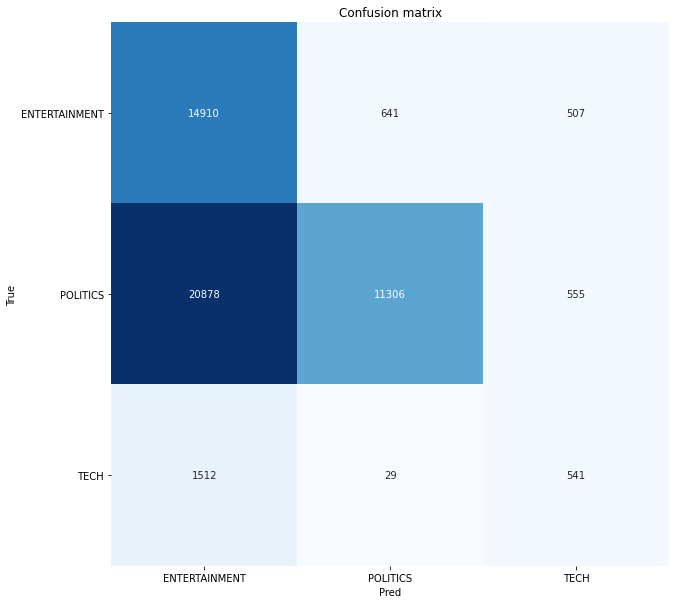

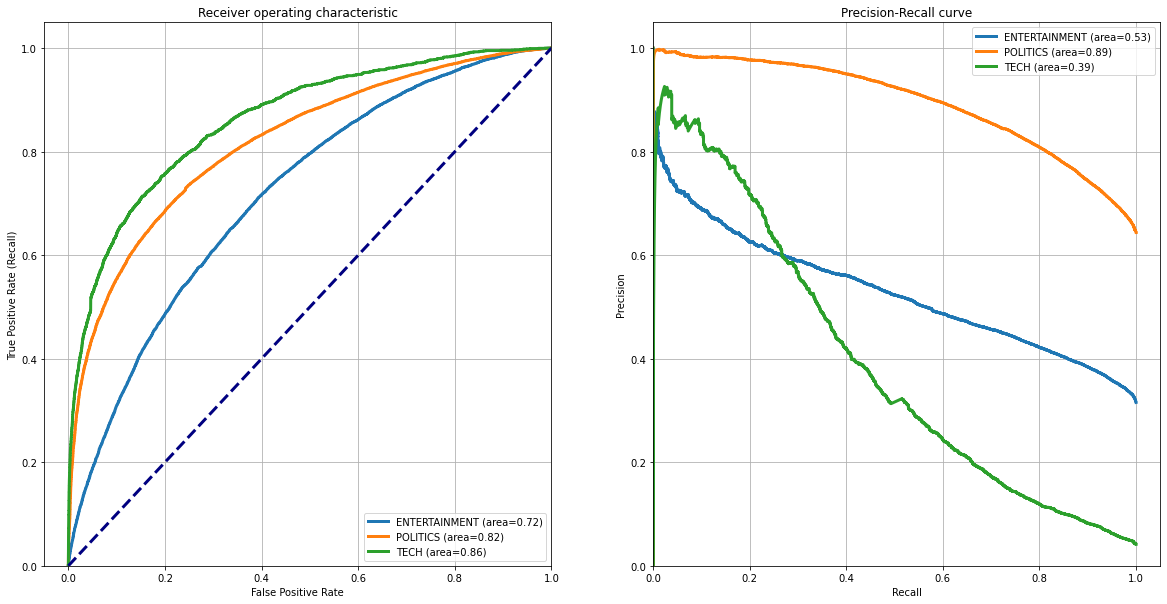

In [39]:
y_test = dtf["category"].values
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3,  label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr)))
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], metrics.auc(recall, precision)))
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Explain predictions

In [181]:
index = 7
txt_instance = dtf["text_clean"].iloc[index]
print("True:", y_test[index], "--> Pred:", predicted[index], "| Similarity:", round(np.max(predicted_prob[index]),2))
print(txt_instance)

True: ENTERTAINMENT --> Pred: ENTERTAINMENT | Similarity: 0.4
mike myers reveals hed like fourth austin power film


- Visualize the mean vector of the article in a 2D space and plot the top similarities with the target cluster

In [184]:
%matplotlib notebook

In [132]:
def embedding_bert(x, tokenizer=None, nlp=None):
    '''
    Creates a feature matrix (num_docs x vector_size)
    :parameter
        :param x: string or list
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
        :param log: bool - print tokens
    :return
        vector or matrix 
    '''
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased') if tokenizer is None else tokenizer
    nlp = transformers.TFBertModel.from_pretrained('bert-base-uncased') if nlp is None else nlp
    
    ## single word --> vec (size,)
    if (type(x) is str) and (len(x.split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp).reshape(-1)
    
    ## list of words --> matrix (n, size)
    elif (type(x) is list) and (type(x[0]) is str) and (len(x[0].split()) == 1):
        X = utils_bert_embedding(x, tokenizer, nlp)
    
    ## list of lists of words --> matrix (n mean vectors, size)
    elif (type(x) is list) and (type(x[0]) is list):
        lst_mean_vecs = [utils_bert_embedding(lst, tokenizer, nlp).mean(0) for lst in x]
        X = np.array(lst_mean_vecs)
    
    ## single text --> matrix (n words, size)
    elif (type(x) is str) and (len(x.split()) > 1):
        X = utils_bert_embedding(x, tokenizer, nlp)
        
    ## list of texts --> matrix (n mean vectors, size)
    else:
        lst_mean_vecs = [utils_bert_embedding(txt, tokenizer, nlp).mean(0) for txt in x]
        X = np.array(lst_mean_vecs)
    return X

<IPython.core.display.Javascript object>


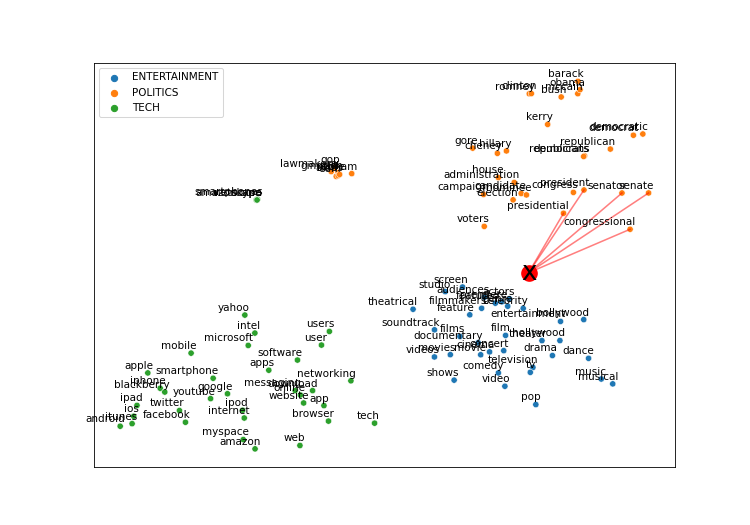

In [185]:
## create embedding Matrix
y = np.concatenate([embedding_bert(v, tokenizer, nlp) for v in dic_clusters.values()])
X = embedding_bert(txt_instance, tokenizer, nlp).mean(0).reshape(1,-1)
M = np.concatenate([y,X])

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
M = pca.fit_transform(M)
y, X = M[:len(y)], M[len(y):]

## create dtf clusters
df = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(df) + len(v)
    df_group = pd.DataFrame(y[len(df):size], columns=["x","y"], index=v)
    df_group["cluster"] = k
    df = df.append(df_group)

## plot clusters
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=df, x="x", y="y", hue="cluster", ax=ax)
#ax.legend().texts[0].set_text(None)
ax.legend()
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
for i in range(len(df)):
    ax.annotate(df.index[i], 
               xy=(df["x"].iloc[i],df["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

## add txt_instance
ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
ax.annotate("x", xy=(X[0][0],X[0][1]), ha='center', va='center', fontsize=25)

## calculate similarity
sim_matrix = metrics.pairwise.cosine_similarity(X, y)

## add top similarity
for row in range(sim_matrix.shape[0]):
    ### sorted {keyword:score}
    dic_sim = {n:sim_matrix[row][n] for n in range(sim_matrix.shape[1])}
    dic_sim = {k:v for k,v in sorted(dic_sim.items(), key=lambda item:item[1], reverse=True)}
    ### plot lines
    for k in dict(list(dic_sim.items())[0:5]).keys():
        p1 = [X[row][0], X[row][1]]
        p2 = [y[k][0], y[k][1]]
        ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
plt.show()

In [187]:
#explainer_similarity_classif(tokenizer, nlp, dic_clusters, txt_instance, token_level=False, top=5, figsize=(10,7))

- Break down the article into tokens to see which ones “activated” the right cluster

In [188]:
def utils_cosine_sim(a, b, nlp=None):
    '''
    Compute cosine similarity between 2 strings or 2 vectors/matrices: cosine_sim = matrix (rows_a x rows_b)
    :parameter
        :param a: string, vector, or matrix
        :param b: string, vector, or matrix
        :param nlp: gensim model - used only if a and b are strings
    :return
        cosine similarity score or matrix
    '''
    ## string vs string = score
    if (type(a) is str) or (type(b) is str):
        nlp = gensim_api.load("glove-wiki-gigaword-300") if nlp is None else nlp
        cosine_sim = nlp.similarity(a,b)
        
    else:
        ## vector vs vector = score
        if (len(a.shape) == 1) and (len(a.shape) == 1):
            a = a.reshape(1,-1)
            b = b.reshape(1,-1)
            cosine_sim = metrics.pairwise.cosine_similarity(a, b)[0][0]  #np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
        
        ## matrix vs matrix = matrix (rows_a x rows_b)
        else:
            a = a.reshape(1,-1) if len(a.shape) == 1 else a
            b = b.reshape(1,-1) if len(b.shape) == 1 else b
            cosine_sim = metrics.pairwise.cosine_similarity(a, b)
    return cosine_sim

In [192]:
def explainer_similarity_classif(tokenizer, nlp, dic_clusters, txt_instance, token_level=False, top=5, figsize=(20,10)):
    '''
    Plot a text instance into a 2d vector space and compute similarity.
    :parameter
        :param tokenizer: transformers tokenizer
        :param nlp: transformers bert
        :param dic_clusters: dict - dict - {0:lst_words, 1:lst_words, ...}
        :param txt_instance: string - raw text
        :param token_level: bool - if True the text is broken down into tokens otherwise the mean vector is taken
        :param top: num - top similarity to display
    '''
    ## create embedding Matrix
    y = np.concatenate([embedding_bert(v, tokenizer, nlp) for v in dic_clusters.values()])
    X = embedding_bert(txt_instance, tokenizer, nlp) if token_level is True else embedding_bert(txt_instance, tokenizer, nlp).mean(0).reshape(1,-1)
    M = np.concatenate([y,X])
    
    ## pca
    pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
    M = pca.fit_transform(M)
    y, X = M[:len(y)], M[len(y):]
    
    ## create dtf clusters
    df = pd.DataFrame()
    for k,v in dic_clusters.items():
        size = len(df) + len(v)
        df_group = pd.DataFrame(y[len(df):size], columns=["x","y"], index=v)
        df_group["cluster"] = k
        df = df.append(df_group)
        
    ## plot clusters
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(data=df, x="x", y="y", hue="cluster", ax=ax)
    #ax.legend().texts[0].set_text(None)
    ax.legend()
    ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], yticks=[], yticklabels=[])
    for i in range(len(df)):
        ax.annotate(df.index[i], xy=(df["x"].iloc[i], df["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    
    ## add txt_instance
    if token_level is True:
        # returns list of words excluding CLS and EOS tokens added during tokenization
        tokens = tokenizer.convert_ids_to_tokens(tokenizer.encode(txt_instance))[1:-1]
        # dataframe with the words as index and rows as embeddings of each word of dim 768
        df_ = pd.DataFrame(X, columns=["x","y"], index=tokens)
        # eliminate index with # (~ returns the complement)
        df_ = df_[~df_.index.str.contains("#")]
        # eliminate one letter index
        df_ = df_[df_.index.str.len() > 1]
        X = df_.values
        ax.scatter(x=df_["x"], y=df_["y"], c="red")
        for i in range(len(df_)):
            ax.annotate(df_.index[i], xy=(df_["x"].iloc[i], df_["y"].iloc[i]), xytext=(5,2), textcoords='offset points', ha='right', va='bottom')
    else:
        ax.scatter(x=X[0][0], y=X[0][1], c="red", linewidth=10)
        ax.annotate("x", xy=(X[0][0],X[0][1]), ha='center', va='center', fontsize=25)
    
    ## calculate similarity
    sim_matrix = utils_cosine_sim(X,y) 

    ## add top similarity
    for row in range(sim_matrix.shape[0]):
        ### sorted {keyword:score}
        dic_sim = {n:sim_matrix[row][n] for n in range(sim_matrix.shape[1])}
        dic_sim = {k:v for k,v in sorted(dic_sim.items(), key=lambda item:item[1], reverse=True)}
        ### plot lines
        for k in dict(list(dic_sim.items())[0:top]).keys():
            p1 = [X[row][0], X[row][1]]
            p2 = [y[k][0], y[k][1]]
            ax.plot([p1[0],p2[0]], [p1[1],p2[1]], c="red", alpha=0.5)
    plt.show()

<IPython.core.display.Javascript object>


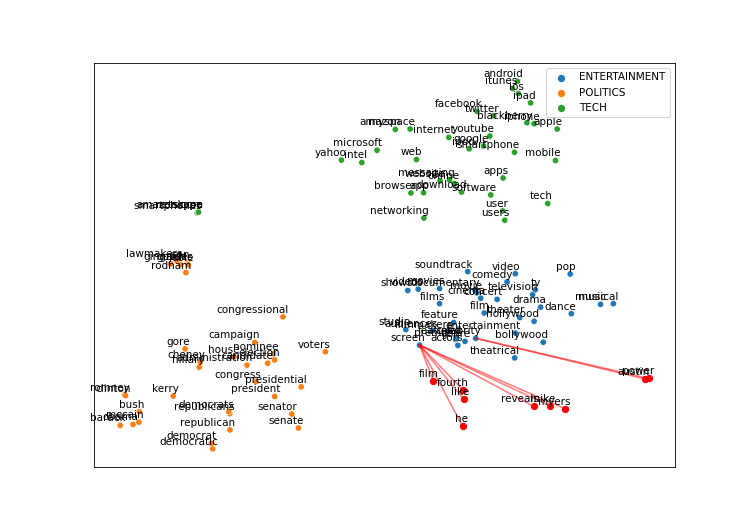

In [194]:
explainer_similarity_classif(tokenizer, nlp, dic_clusters, dtf["text_clean"].iloc[index], token_level=True, top=1, figsize=(10,7))

In [173]:
%matplotlib inline